# Welcome to the YOLO Workshop!

In this workshop, we will learn how to use the YOLO algorithm for object detection

## Import the necessary libraries
We will need OpenCV, Matplotlib, and NumPy

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

## Define the class YOLO and the init() function

In [2]:
class YOLO():
    def __init__(self):
        """
        - YOLO takes an image as input. We should set the dimension of the image to a fixed number.
        - The default choice is often 416x416.
        - YOLO applies thresholding and non maxima suppression, define a value for both
        - Load the classes, model configuration (cfg file) and pretrained weights (weights file) into variables
        - If the image is 416x416, the weights must be corresponding to that image
        - Load the network with OpenCV.dnn function
        """
        self.confThreshold = 0.5
        self.nmsThreshold = 0.4
        self.inpWidth = 416
        self.inpHeight = 416
        classesFile = "./coco.names"
        self.classes = None
        with open(classesFile,'rt') as f:
            self.classes = f.read().rstrip('\n').split('\n')
        modelConfiguration = "./yolov3.cfg";
        modelWeights = "./yolov3.weights";
        self.i = 0
        self.net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
        self.net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
        self.net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

In [3]:
def getOutputsNames(self):
    '''
    Get the names of the output layers
    '''
    # Get the names of all the layers in the network
    layersNames = self.net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in self.net.getUnconnectedOutLayers()]

YOLO.getOutputsNames = getOutputsNames

In [4]:
def drawPred(self, frame, classId, conf, left, top, right, bottom):
    '''
    Draw a bounding box around a detected object given the box coordinates
    Later, we could repurpose that to display an ID
    '''
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), thickness=2)
    label = '%.2f' % conf
    # Get the label for the class name and its confidence
    if self.classes:
        assert(classId < len(self.classes))
        label = '%s:%s' % (self.classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)
    return frame
    
YOLO.drawPred = drawPred

In [5]:
def postprocess(self, frame, outs):
    """
    Postprocessing step. Take the output out of the neural network and interpret it.
    We should use that output to apply NMS thresholding and confidence thresholding
    We should use the output to draw the bounding boxes using the dramPred function
    """
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > self.confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])
    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, self.confThreshold, self.nmsThreshold)
    
    output_image = frame
    
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        output_image = self.drawPred(frame,classIds[i], confidences[i], left, top, left + width, top + height)
    return output_image

YOLO.postprocess = postprocess

In [6]:
def inference(self,image):
    """
    Main loop.
    Input: Image
    Output: Frame with the drawn bounding boxes
    """
    # Create a 4D blob from a frame.
    blob = cv.dnn.blobFromImage(image, 1/255, (self.inpWidth, self.inpHeight), [0,0,0], 1, crop=False)
    # Sets the input to the network
    self.net.setInput(blob)
    # Runs the forward pass to get output of the output layers
    outs = self.net.forward(self.getOutputsNames())
    # Remove the bounding boxes with low confidence
    final_frame = self.postprocess(image, outs)
    self.i +=1
    return final_frame

YOLO.inference = inference

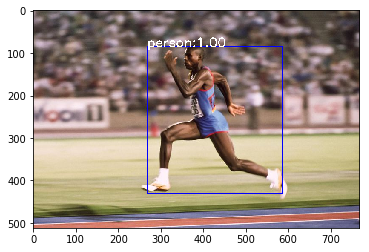

In [7]:
img = mpimg.imread("./test_images/runner.jpg")
yolo = YOLO()
oi = yolo.inference(img)
plt.imshow(oi)
plt.show()

### Detection on a video!

A video is just a set of frames, we will call the inference function for each frame of the video and save it.


In [8]:
from moviepy.editor import VideoFileClip
video_file = "./test_videos/input.mp4"
clip = VideoFileClip(video_file)
white_clip = clip.fl_image(yolo.inference)
%time white_clip.write_videofile("movie.mp4",audio=False)

t:   0%|          | 0/380 [00:00<?, ?it/s, now=None]Moviepy - Building video movie.mp4.
Moviepy - Writing video movie.mp4

t: 100%|██████████| 380/380 [04:54<00:00,  1.29it/s, now=None]Moviepy - Done !
Moviepy - video ready movie.mp4
Wall time: 4min 55s


In [9]:
import io
import base64
from IPython.display import HTML

video = io.open('movie.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls width="320" height="240">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))) 

In [10]:
from IPython.display import Video

Video("movie.mp4")